In [54]:
from absl import logging

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image, ImageOps
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform
from six import BytesIO

import tensorflow as tf

import tensorflow_hub as hub
from six.moves.urllib.request import urlopen

## The data

In the next cell, we specify the URLs of two images we would like to process with DELF in order to match and compare them.

In [55]:
#@title Choose images
images = "Bridge of Sighs" #@param ["Bridge of Sighs", "Golden Gate", "Acropolis", "Eiffel tower"]
if images == "Bridge of Sighs":
  # from: https://commons.wikimedia.org/wiki/File:Bridge_of_Sighs,_Oxford.jpg
  # by: N.H. Fischer
  IMAGE_1_URL = 'https://upload.wikimedia.org/wikipedia/commons/2/28/Bridge_of_Sighs%2C_Oxford.jpg'
  # from https://commons.wikimedia.org/wiki/File:The_Bridge_of_Sighs_and_Sheldonian_Theatre,_Oxford.jpg
  # by: Matthew Hoser
  IMAGE_2_URL = 'https://upload.wikimedia.org/wikipedia/commons/c/c3/The_Bridge_of_Sighs_and_Sheldonian_Theatre%2C_Oxford.jpg'
elif images == "Golden Gate":
  IMAGE_1_URL = 'https://upload.wikimedia.org/wikipedia/commons/1/1e/Golden_gate2.jpg'
  IMAGE_2_URL = 'https://upload.wikimedia.org/wikipedia/commons/3/3e/GoldenGateBridge.jpg'
elif images == "Acropolis":
  IMAGE_1_URL = 'https://upload.wikimedia.org/wikipedia/commons/c/ce/2006_01_21_Ath%C3%A8nes_Parth%C3%A9non.JPG'
  IMAGE_2_URL = 'https://upload.wikimedia.org/wikipedia/commons/5/5c/ACROPOLIS_1969_-_panoramio_-_jean_melis.jpg'
else:
  IMAGE_1_URL = 'https://upload.wikimedia.org/wikipedia/commons/d/d8/Eiffel_Tower%2C_November_15%2C_2011.jpg'
  IMAGE_2_URL = 'https://upload.wikimedia.org/wikipedia/commons/a/a8/Eiffel_Tower_from_immediately_beside_it%2C_Paris_May_2008.jpg'

Download, resize, save and display the images.

In [56]:
def download_and_resize(name, url, new_width=256, new_height=256):
  path = tf.keras.utils.get_file(url.split('/')[-1], url)
  image = Image.open(path)
  image = ImageOps.fit(image, (new_width, new_height), Image.ANTIALIAS)
  return image

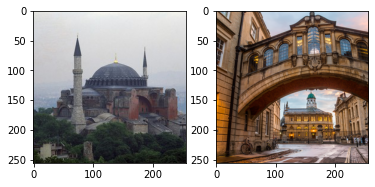

In [66]:
image1 = Image.open('./images/resized\\pic_001.jpg')
image1 = ImageOps.fit(image1, (256, 256), Image.ANTIALIAS)
image2 = download_and_resize('image_2.jpg', IMAGE_2_URL)

plt.subplot(1,2,1)
plt.imshow(image1)
plt.subplot(1,2,2)
plt.imshow(image2)

## Apply the DELF module to the data

The DELF module takes an image as input and will describe noteworthy points with vectors. The following cell contains the core of this colab's logic.

In [61]:
delf = hub.load('https://tfhub.dev/google/delf/1').signatures['default']

In [62]:
def run_delf(image):
  np_image = np.array(image)
  float_image = tf.image.convert_image_dtype(np_image, tf.float32)

  return delf(
      image=float_image,
      score_threshold=tf.constant(100.0),
      image_scales=tf.constant([0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0]),
      max_feature_num=tf.constant(1000))

In [63]:
result1 = run_delf(image1)
print(result1)
result2 = run_delf(image2)

{'attention': <tf.Tensor: shape=(207,), dtype=float32, numpy=
array([574.31244 , 515.74725 , 438.6516  , 431.83936 , 431.53564 ,
       423.36823 , 421.36584 , 415.91568 , 415.8139  , 386.22003 ,
       364.51642 , 363.52637 , 355.88303 , 348.85684 , 340.99896 ,
       334.98627 , 333.2661  , 319.65997 , 305.02316 , 303.28622 ,
       290.01367 , 285.5901  , 278.19904 , 277.81888 , 276.85748 ,
       275.0364  , 273.35938 , 272.20056 , 271.8739  , 266.677   ,
       263.91592 , 259.45554 , 255.65799 , 253.18462 , 250.83336 ,
       246.23698 , 243.48332 , 238.03941 , 236.52232 , 233.60371 ,
       232.79686 , 231.65514 , 229.29692 , 223.97331 , 220.04591 ,
       219.84587 , 219.5504  , 213.40923 , 210.17635 , 204.81654 ,
       204.79999 , 202.46375 , 201.28441 , 201.28401 , 200.65802 ,
       196.68843 , 195.99959 , 193.68956 , 191.7556  , 191.68031 ,
       189.04796 , 188.82515 , 187.80194 , 186.86995 , 186.67645 ,
       185.8667  , 181.22197 , 179.61023 , 178.91042 , 177.22737 ,


## Use the locations and description vectors to match the images

In [64]:
#@title TensorFlow is not needed for this post-processing and visualization
def match_images(image1, image2, result1, result2):
    distance_threshold = 0.8

    # Read features.
    num_features_1 = result1['locations'].shape[0]
    print("Loaded image 1's %d features" % num_features_1)

    num_features_2 = result2['locations'].shape[0]
    print("Loaded image 2's %d features" % num_features_2)

    # Find nearest-neighbor matches using a KD tree.
    d1_tree = cKDTree(result1['descriptors'])
    _, indices = d1_tree.query(
      result2['descriptors'],
      distance_upper_bound=distance_threshold)

    # Select feature locations for putative matches.
    locations_2_to_use = np.array([result2['locations'][i,] for i in range(num_features_2) if indices[i] != num_features_1])
    locations_1_to_use = np.array([
      result1['locations'][indices[i],]
      for i in range(num_features_2)
      if indices[i] != num_features_1
    ])

    # Perform geometric verification using RANSAC.
    _, inliers = ransac(
      (locations_1_to_use, locations_2_to_use),
      AffineTransform,
      min_samples=3,
      residual_threshold=20,
      max_trials=1000)

    print('Found %d inliers' % sum(inliers))

    # Visualize correspondences.
    _, ax = plt.subplots()
    inlier_idxs = np.nonzero(inliers)[0]
    plot_matches(
      ax,
      image1,
      image2,
      locations_1_to_use,
      locations_2_to_use,
      np.column_stack((inlier_idxs, inlier_idxs)),
      matches_color='b')
    ax.axis('off')
    ax.set_title('DELF correspondences')
    plt.show()

Loaded image 1's 207 features
Loaded image 2's 262 features
Found 3 inliers


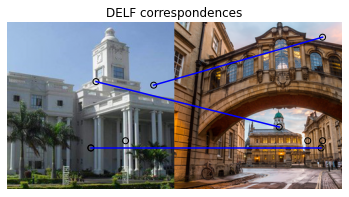

In [65]:
match_images(image1, image2, result1, result2)